In [1]:
from collections import namedtuple
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes
import pandas as pd
from pathlib import Path
from functools import partial
import itertools
from itertools import combinations
import re
import requests
import json
import scipy as sp
import scipy.stats
import sklearn
import sys
import time
import pyext.src.pynet_rng as rng
import timeit
import pyext.src.matrix as mat
import pyext.src.stats as stats

from src.wishart_synthetic_benchmark import (
    ccscatter,
    df_from_stats,
    get_precision_matrix_stats,
    get_prior_pred,
    helper_vline_hist,
    margins_plot,
    quad_plot,
    randPOSDEFMAT,
    rprior,
    rprior_pred,
    sample_from_prior,
    scatter_plot,
    simulate_from_prior,
    try_sampling,
    ground_truth_pair_plot
)

In [2]:
# Flags
MICRO_BENCHMARK_SAMPLING = False
eig10k = False
PAIR_PLOTS = False

In [3]:
# Global Notebook Variables
key = jax.random.PRNGKey(13)
n = 4
shape = 1
dim = 4
df = 2
p = 4

# Image Generating Values From a 2-d Gaussian

xy = -0.9
xx = 1.
yy = 1.
cov = jnp.array([[xx, xy],
                 [xy, yy]])
N=1000

mean = jnp.zeros(2)
data = jax.random.multivariate_normal(key, mean, cov, shape=(N,))

In [4]:
x_stats = stats.get_stats(data[:, 0])
y_stats = stats.get_stats(data[:, 1])

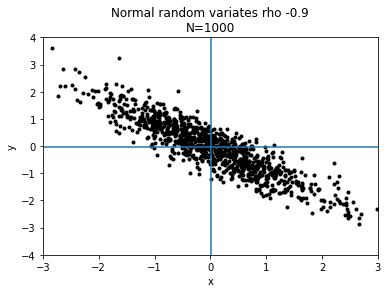

In [5]:
scatter_plot(data[:, 0], data[:, 1], xy=xy)

/home/aji/anaconda3/envs/pynetp3.10.0/lib/python3.10/site-packages/matplotlib/axes/_base.py:2475: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


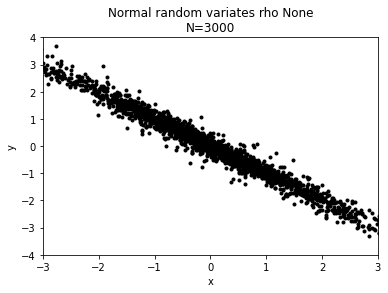

In [6]:
scale = 1.
xy = -0.99
cov_prior = jnp.array([[scale, xy],
                       [xy, scale]])

assert mat.is_positive_definite(cov_prior)

n_samples = 1000
val = jax.jit(partial(get_prior_pred, V=cov_prior, n_samples=n_samples))(key)

x = np.ravel(val.data[:, :, 0])
y = np.ravel(val.data[:, :, 1])
scatter_plot(x, y, )

In [7]:
# What is the largest Matrix this will work on?
if MICRO_BENCHMARK_SAMPLING:
    for p in [24, 48, 96, 128, 256, 512, 1024]:
        try_sampling(key, p)

In [8]:
# What about inverse Covariance Matrices?

"""
Synthetic Data Setup
  64 member pulldown
  4 replicates
  Correlation Structure
    view the image
  mean vector
  
  view the correlation matrix
  view the empircal correlation
  view the precision matrix

Model - Prior Predictive Check
    K ~ Wish
    Sigma = inv(K)
    D ~ N(0, Sigma)
    
Gaussian Model
Updated.
"""

'\nSynthetic Data Setup\n  64 member pulldown\n  4 replicates\n  Correlation Structure\n    view the image\n  mean vector\n  \n  view the correlation matrix\n  view the empircal correlation\n  view the precision matrix\n\nModel - Prior Predictive Check\n    K ~ Wish\n    Sigma = inv(K)\n    D ~ N(0, Sigma)\n    \nGaussian Model\nUpdated.\n'

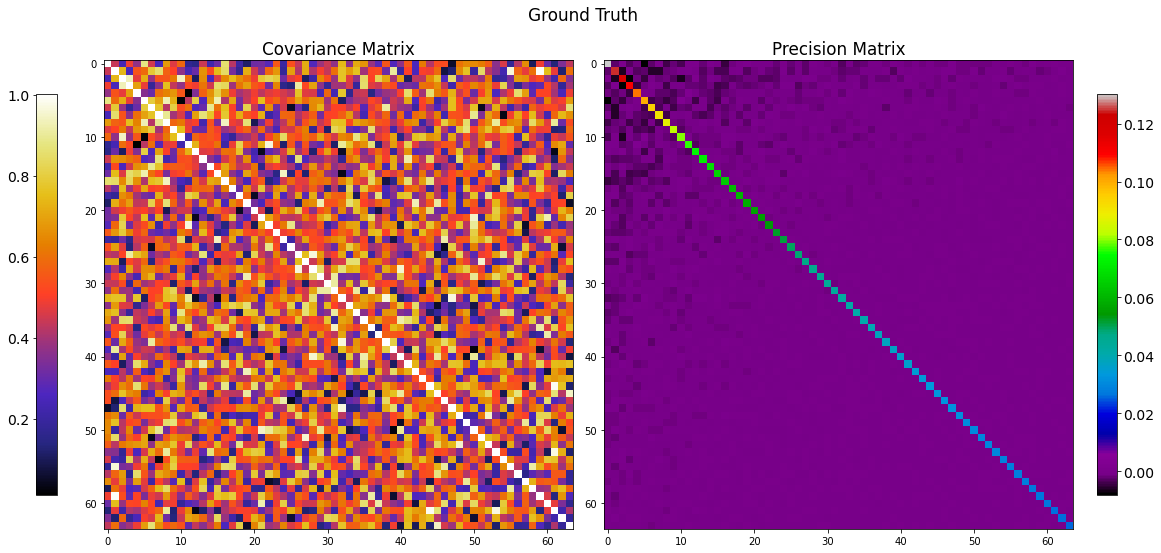

In [9]:
p = 64
k = jax.random.PRNGKey(234762834)
k, k1, k2 = jax.random.split(k, 3)
A = randPOSDEFMAT(k, p)
diag_idx = np.diag_indices(p)
A = A.at[diag_idx].set(jnp.sqrt(A[diag_idx]) + jnp.arange(p) / 2).block_until_ready()
A = np.array(A)
assert np.alltrue(A[diag_idx] > 0)
assert mat.is_positive_definite(A)

n_replicates = 4
mus = jax.random.normal(k1, shape=(p,))*5
data = jax.random.multivariate_normal(k2, mus, A, shape=(n_replicates,))

assert mat.is_positive_definite(A)

K = np.linalg.inv(A)
assert np.alltrue(K[diag_idx] > 0)
assert np.alltrue(K[diag_idx] > 0)
assert mat.is_positive_definite(K)
#K =  K / np.abs((np.max(K) - np.min(K))) # put two -1, 1
#K = K * 2

font_rc = {"size": 14, "family": "sans-serif"}

scale = 16
w = 1 * scale
h = 1 * scale
cmap1 = "CMRmap"#"nipy_spectral" #"CMRmap"\
cmap2 = "nipy_spectral"
cbar_scale = 0.35

fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios':[1, 1],
                                           'height_ratios':[1]}, layout="constrained")

plt.rc("font", **font_rc)
fig.set_figheight(h)
fig.set_figwidth(w)
ax = axs[0]


covim = ax.imshow(A, vmin=np.min(A), vmax=2*np.median(A), cmap=cmap1)
fig.colorbar(covim, ax=ax, location="left", shrink=0.35)
ax.set_title("Covariance Matrix")

ax = axs[1]
ax.set_title("Precision Matrix")
precim = ax.imshow(K, vmin=np.min(K), vmax=np.max(K), cmap=cmap2)
fig.colorbar(precim, ax=ax, location="right", shrink=cbar_scale)
plt.suptitle("Ground Truth", y=0.75)
plt.show()

The covariance matrix $A$  
The precision matrix $K=A^{-1}$

In the covariance matrix the off diagonal elements are only dependant on columns X and Y

#### Covariance Matrix $A$
- Diagonals are the Variances
- Off Diagonals are the Covariances (un-normalized correlation)

#### Correlation Matrix corr:
- The covariance matrix of standardized normal variates
- The diagonals are 1
- The off-diagonals are the correlations
  
#### Precision Matrix $K$
$$p_{ij} = K_{ij}$$ Precision matrix off diagonal
partial_correlation 
$$\rho_{X_iX_j\cdot V}=-\frac{K_{ij}}{\sqrt{p_{ii}p_{ij}}}$$



In [10]:

data = np.array(data)
data = data.T
data = pd.DataFrame(data=data)
data["means"] = data.apply(np.mean, axis=1)
data["stds"] = data.apply(np.std, axis=1)
data["vars"] = data.apply(np.var, axis=1)
data["medians"] = data.apply(np.median, axis=1)
diag_idx = np.diag_indices(p)
data["mu"] = np.array(mus)
data["Aii"] = np.array(A[diag_idx])
data["Kii"] = np.array(K[diag_idx])

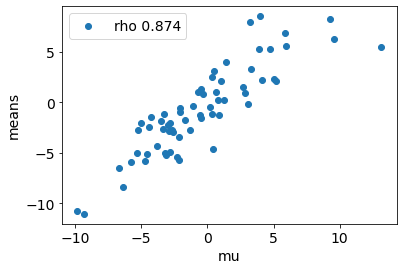

In [11]:
ccscatter(data.mu, data.means)

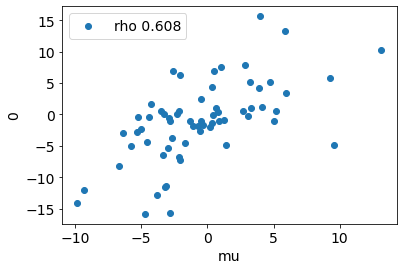

In [12]:
ccscatter(data.mu, data.loc[:, 0])

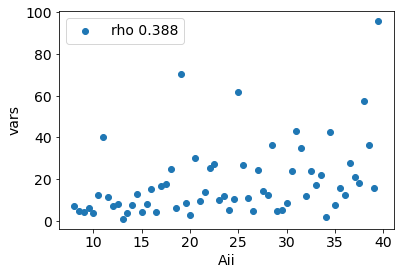

In [13]:
ccscatter(data.Aii, data.vars)

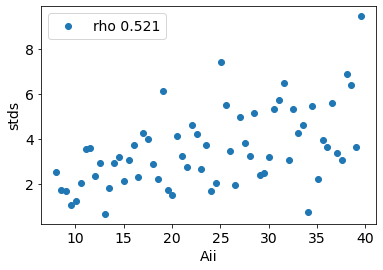

In [14]:
ccscatter(data.Aii, data.stds)

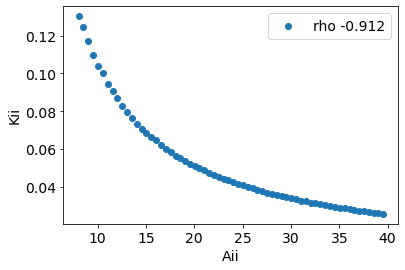

In [15]:
ccscatter(data.Aii, data.Kii)

#### Model 1
 - 64 Independant Gaussians parameterized by their mean and variance
 $$p(d_i | \mu_i, \tau_i) = N(\mu, \tau)$$
 $$ \mu \sim N(\mu_0, 1)$$
 $$ \tau \sim \text{Beta} $$
 $$d_i \sim N(\mu, \tau) $$ 
 
#### Model 2

$$ D \sim N(\mu, \Sigma^{-1})$$

$$ \mu \sim N(\mu_0, \tau_0) $$

$$ \Sigma^{-1} \sim \mathcal{W}_p(\nu, K_0)$$
 - Data $D$ with $n$ replicates and $p$ nodes
 - A $p$ variate Gaussian distribution with
 - $\nu$ degrees of freedom
 - $V$ scale matrix
 - $K_0 = V^{-1}$
 - $n$ observations
 - $p$ variables
 - $Z = D \cdot D^{T}$
 $$ D \sim W_{p}(n + \nu, \space K_0 + Z^{-1}) $$
 
#### Prior Predicitve Check Metrics

#### Prior Comparisons to Ground Truth

$$ K \sim \mathcal{W}_p(\nu, K_0) $$

- sum of the rows
- sum of the columns
- sum of the trace
- min
- max

#####  p-variate metrics
- mean values
- medians
- variances
- min
- max

##### Eigen-values

In [16]:
K_0 = jnp.ones(p) * 0.5 + jnp.eye(p)
n_samples = 1000

jss = jax.jit(partial(sample_from_prior, K_0=K_0, nu=p, p=p, n_samples=n_samples))

val = jss(key)

mat_stats = [get_precision_matrix_stats(K, n) for K in val.samples]

prior_mat_stat_df = df_from_stats(mat_stats, n)
#prior_mat_stat_df = prior_mat_stat_df.iloc[:, 1:-1]

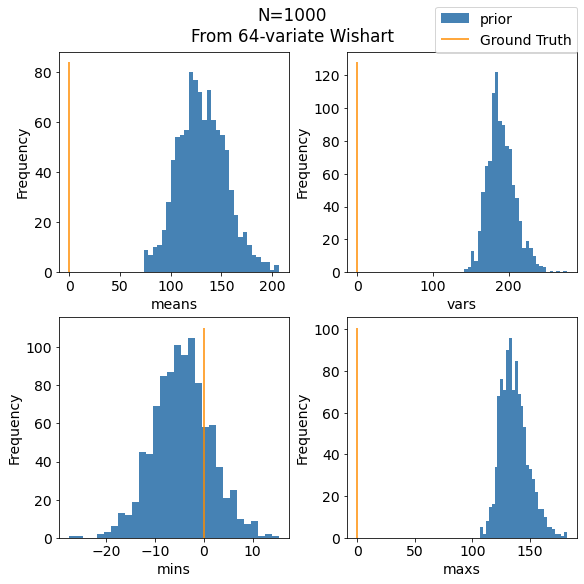

In [17]:
# Initial Model Results
suptitle = f"N={n_samples}\nFrom {p}-variate Wishart"
quad_plot(prior_mat_stat_df, K, n, n_samples, font_rc=font_rc, p=p, suptitle=suptitle)

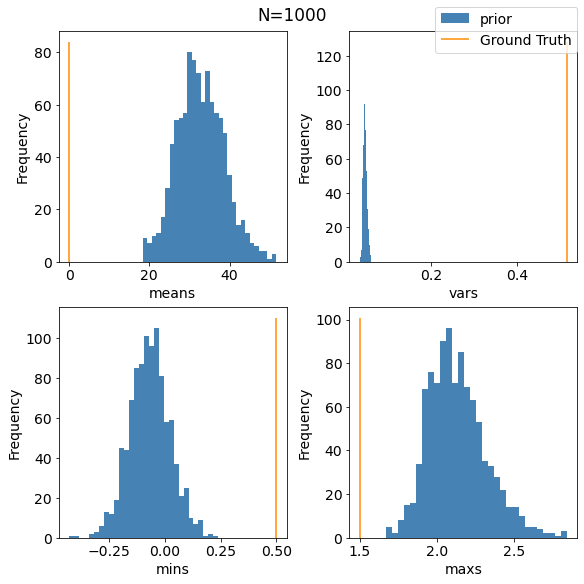

In [18]:
# Try a new K0, reuse key
p=64
n=64
ground_truth = K_0
K0 = 1/n * K_0
n_samples = 1000
jss = jax.jit(partial(sample_from_prior, K_0=K0, nu=p, p=p, n_samples=n_samples))
val = jss(key)
stats = [get_precision_matrix_stats(K, n) for K in val.samples]
df = df_from_stats(stats, n)
quad_plot(df, ground_truth, n_samples=n_samples,
         n=n,
         font_rc=font_rc, p=p)

In [19]:
# Try a new K0, reuse key

p=64
n=64
K0 = 1/n * K
n_samples = 10000
jss = jax.jit(partial(sample_from_prior, K_0=K0, nu=p, p=p, n_samples=n_samples))
val = jss(key)
stats = [get_precision_matrix_stats(K, n) for K in val.samples]
df = df_from_stats(stats, n=n)

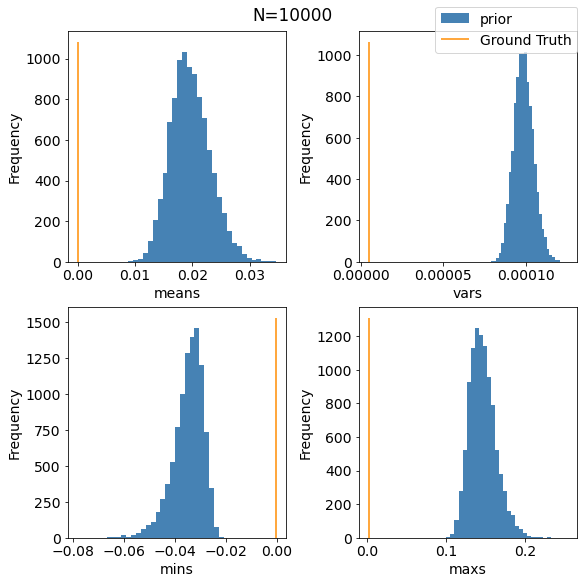

In [20]:
quad_plot(df, K0, n=n, n_samples=n_samples, font_rc=font_rc, p=p)

In [21]:
# Lets look at the top 4 eigenvalues

if eig10k:
    ground_truth = sp.linalg.eigh(K, eigvals_only=True, check_finite=True)

    eigs = np.zeros((len(val.samples), p))
    for i in range(len(val.samples)):
        eigs[i] = sp.linalg.eigh(val.samples[i], eigvals_only=True, check_finite=True)
    

In [22]:
if PAIR_PLOTS:
    m = 8
    scale = 16
    w = 1 * scale
    h = 1 * scale
    bins=30
    hcolor="steelblue"
    vcolor="darkorange"
    fig, axs = plt.subplots(m, m, layout="constrained")
    fig.set_figheight(h)
    fig.set_figwidth(w)

    count = -1
    for i in range(m):
        for j in range(m):
            count +=1
            ax = axs[i, j]
            eigvals = eigs[:, count]
            vx = ground_truth[count]
            ymin = 0

            vlabel = f"K eigenvalues" if count == m*m-1 else None
            hlabel = f"prior samples" if count == m*m-1 else None

            #helper_vline_hist(ax, vx, ymin, ymax, eigvals, vlabel, hlabel,
                             #vcolor, hcolor, bins, ylabel=None, xlabel=None)



            ax.hist(eigvals, bins=bins, label=hlabel, facecolor=hcolor)
            ymax = ax.get_ylim()[1]
            ax.vlines(x=truth, ymin=0, ymax=ymax, color=vcolor)

            #ax.scatter(x, y)
        plt.suptitle(f"N={n_samples}")
    plt.show()

In [23]:
# A simpler Case

cov = np.array([[1., -0.2],
                [-0.2, 1.]])

cov_inv = sp.linalg.inv(cov)
nu = 2
n=2
p = 2
K0 = (1/nu)*cov_inv
n_samples = 1000

key = jax.random.PRNGKey(22)
samples = sample_from_prior(key, nu, p, n_samples, K0)

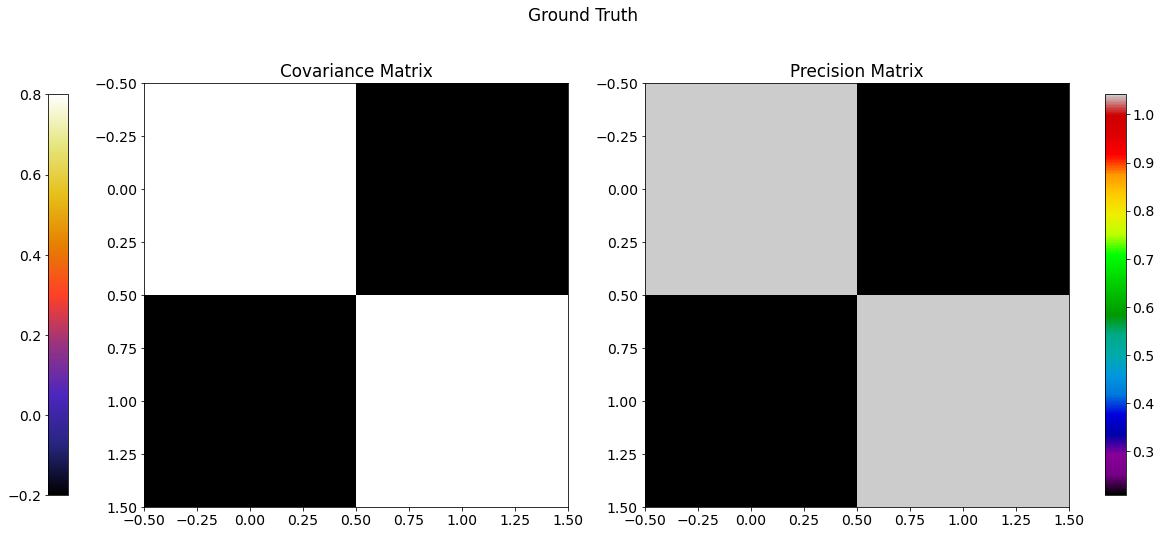

In [24]:
t1 = A
t2 = K
A = cov
K = cov_inv
font_rc = {"size": 14, "family": "sans-serif"}

scale = 16
w = 1 * scale
h = 1 * scale
cmap1 = "CMRmap"#"nipy_spectral" #"CMRmap"\
cmap2 = "nipy_spectral"
cbar_scale = 0.35

fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios':[1, 1],
                                           'height_ratios':[1]}, layout="constrained")

plt.rc("font", **font_rc)
fig.set_figheight(h)
fig.set_figwidth(w)
ax = axs[0]


covim = ax.imshow(A, vmin=np.min(A), vmax=2*np.median(A), cmap=cmap1)
fig.colorbar(covim, ax=ax, location="left", shrink=0.35)
ax.set_title("Covariance Matrix")

ax = axs[1]
ax.set_title("Precision Matrix")
precim = ax.imshow(K, vmin=np.min(K), vmax=np.max(K), cmap=cmap2)
fig.colorbar(precim, ax=ax, location="right", shrink=cbar_scale)
plt.suptitle("Ground Truth", y=0.75)
plt.show()
A = t1
K = t2

In [25]:
mat_stats = [get_precision_matrix_stats(K, n, p=p) for K in samples.samples]

prior_mat_stat_df = df_from_stats(mat_stats, n)

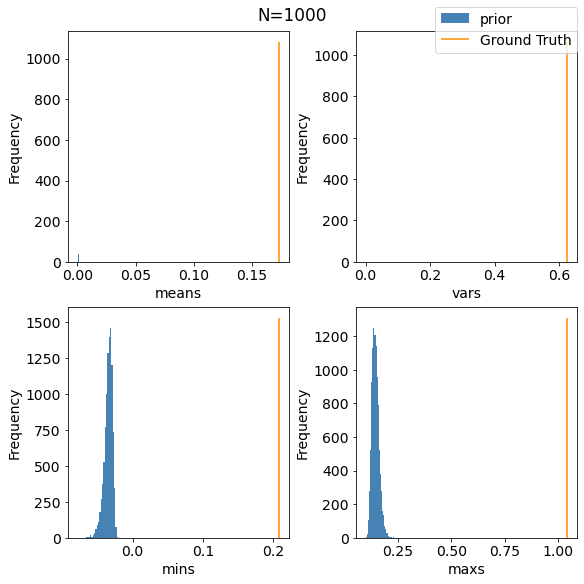

In [26]:
quad_plot(df, cov_inv, n=n, n_samples=n_samples, font_rc=font_rc, p=p)

In [27]:
ground_truth = sp.linalg.eigh(cov_inv, eigvals_only=True, check_finite=True)

eigs = np.zeros((len(samples.samples), p))
for i in range(len(samples.samples)):
    eigs[i] = sp.linalg.eigh(samples.samples[i], eigvals_only=True, check_finite=True)

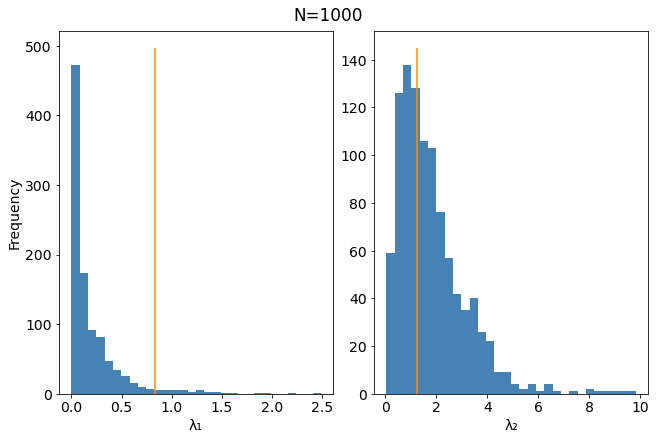

In [28]:
m = 2
scale = 6
w = 1.5 * scale
h = 1 * scale
bins=30
hcolor="steelblue"
vcolor="darkorange"

font_rc = {"size": 16, "family": "sans-serif"}
fig, axs = plt.subplots(1, 2, layout="constrained")
fig.set_figheight(h)
fig.set_figwidth(w)

count = -1
axs[0].set_ylabel("Frequency")
for i in range(m):
    count +=1
    ax = axs[i]
    eigvals = eigs[:, count]
    vx = ground_truth[count]
    ymin = 0

    vlabel = f"K eigenvalues" if count == m*m-1 else None
    hlabel = f"prior samples" if count == m*m-1 else None

    #helper_vline_hist(ax, vx, ymin, ymax, eigvals, vlabel, hlabel,
                     #vcolor, hcolor, bins, ylabel=None, xlabel=None)


    truth = ground_truth[count]
    ax.hist(eigvals, bins=bins, label=hlabel, facecolor=hcolor)
    ymax = ax.get_ylim()[1]
    ax.vlines(x=truth, ymin=0, ymax=ymax, color=vcolor)

    s = u"\u03BB"
    SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
    s = s + str(count + 1)
    s = s.translate(SUB)
    ax.set_xlabel(s)
    #ax.scatter(x, y)
    
    plt.suptitle(f"N={n_samples}")
plt.show()

In [29]:
# More Complex 3 x 3

cov = np.array([[1., 0., 0.2],
                [0., 0.3, -0.5],
                [0.2, -0.5, 1.3]])

assert mat.is_positive_definite(cov)

cov_inv = sp.linalg.inv(cov)
nu = 3
n=3
p = 3
K0 = (1/nu)*cov_inv
n_samples = 1000

key = jax.random.PRNGKey(22)

samples = sample_from_prior(key, nu, p, n_samples, K0)

In [30]:
mat_stats = [get_precision_matrix_stats(K, n, p=p) for K in samples.samples]

prior_mat_stat_df = df_from_stats(mat_stats, n)

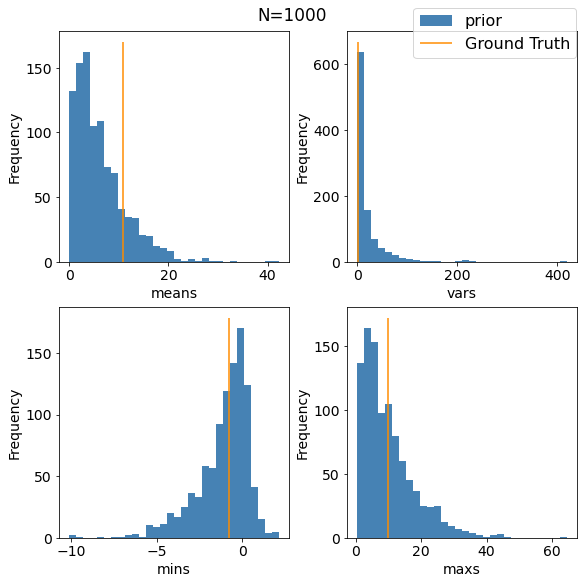

In [31]:
quad_plot(prior_mat_stat_df, cov_inv, n=n, n_samples=n_samples, font_rc=font_rc, p=p)

In [32]:
ground_truth = sp.linalg.eigh(cov_inv, eigvals_only=True, check_finite=True)

eigs = np.zeros((len(samples.samples), p))
for i in range(len(samples.samples)):
    eigs[i] = sp.linalg.eigh(samples.samples[i], eigvals_only=True, check_finite=True)

In [33]:
assert ground_truth.shape == (3,)
assert eigs.shape == (n_samples, 3)

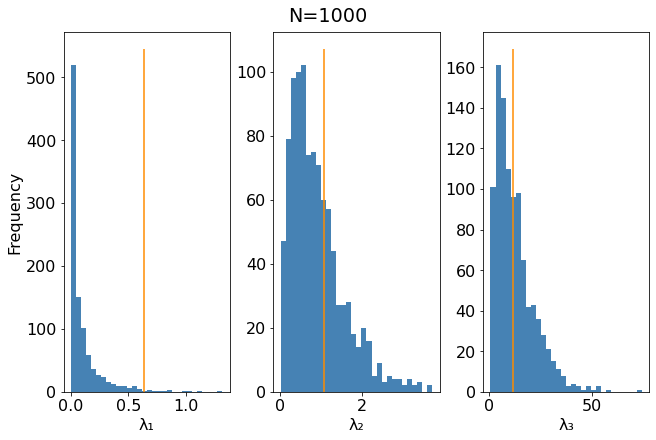

In [34]:
m = 3
scale = 6
w = 1.5 * scale
h = 1 * scale
bins=30
hcolor="steelblue"
vcolor="darkorange"

font_rc = {"size": 16, "family": "sans-serif"}
fig, axs = plt.subplots(1, m, layout="constrained")
fig.set_figheight(h)
fig.set_figwidth(w)

count = -1
axs[0].set_ylabel("Frequency")
for i in range(m):
    count +=1
    ax = axs[i]
    eigvals = eigs[:, count]
    vx = ground_truth[count]
    ymin = 0

    vlabel = f"K eigenvalues" if count == m*m-1 else None
    hlabel = f"prior samples" if count == m*m-1 else None

    #helper_vline_hist(ax, vx, ymin, ymax, eigvals, vlabel, hlabel,
                     #vcolor, hcolor, bins, ylabel=None, xlabel=None)


    truth = ground_truth[count]
    ax.hist(eigvals, bins=bins, label=hlabel, facecolor=hcolor)
    ymax = ax.get_ylim()[1]
    ax.vlines(x=truth, ymin=0, ymax=ymax, color=vcolor)

    s = u"\u03BB"
    SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
    s = s + str(count + 1)
    s = s.translate(SUB)
    ax.set_xlabel(s)
    #ax.scatter(x, y)
    
    plt.suptitle(f"N={n_samples}")
plt.show()

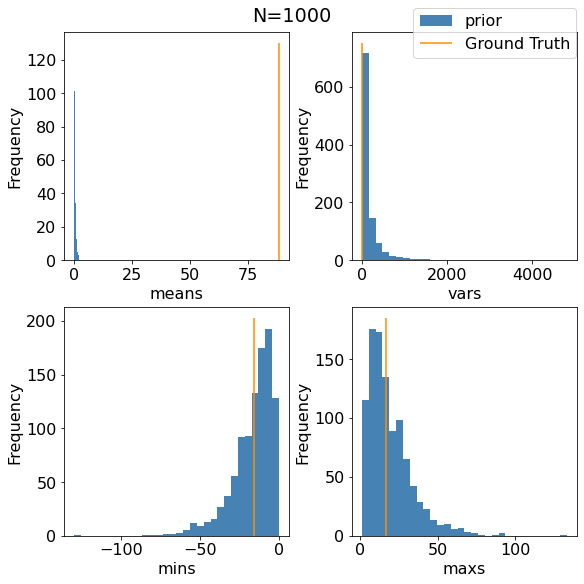

In [35]:
# More Complex 4x4
def set_up_synth_exp(key, nu, cov,):
    SynthExper = namedtuple("SynthExp", "cov cov_inv nu n p K0 n_samples key samples")
    assert mat.is_positive_definite(cov)

    cov_inv = sp.linalg.inv(cov)
    n=len(cov)
    p = len(cov)
    K0 = (1/nu)*cov_inv
    n_samples = 1000

    key = jax.random.PRNGKey(22)

    samples = sample_from_prior(key, nu, p, n_samples, K0)
    return SynthExper(cov, cov_inv, nu, n, p, K0, n_samples, key, samples)

cov = np.array([[1.1,  0.0, 0.1, 1.],
                [0.,  1.2, 1., 0.],
                [0.1, 1.0,  1.1,0.],
                [1.,  0.,  0., 1.]])


def check_cov(m):
    assert np.alltrue(m[np.diag_indices(len(m))] > 0), f"fail : diag"
    assert np.alltrue(cov == cov.T)
    assert mat.is_positive_definite(m), f"fail pos"
    
def do_quad_plot(exp, font_rc={"size": 16}):
    mat_stats = [get_precision_matrix_stats(S, exp.n, p=exp.p) for S in exp.samples.samples]
    prior_mat_stat_df = df_from_stats(mat_stats, exp.n)
    quad_plot(prior_mat_stat_df, exp.cov_inv, n=exp.n, n_samples=exp.n_samples, font_rc=font_rc, p=exp.p)

key = jax.random.PRNGKey(4)
ex4 = set_up_synth_exp(key, nu, cov)
do_quad_plot(ex4)

In [36]:
def do_gridplot(
    exp,
    scale = 6,
    w = 1.5 * scale,
    h = 1 * scale,
    bins=30,
    hcolor="steelblue",
    vcolor="darkorange",

    font_rc = {"size": 16, "family": "sans-serif"}, 
    check_finite=True,
    decomposition="eigh"):
    
    

    if decomposition == "eigh":
        def decomp(x):
            return sp.linalg.eigh(x, eigvals_only=True, check_finite=check_finite)
    
    elif decomposition == "svd":
        def decomp(x):
            U, s, VH = sp.linalg.svd(x)
            return s
    elif decomposition == "prec":
        def decomp(x):
            return x[np.diag_indices(len(x))]
        
    ground_truth = decomp(exp.cov_inv)
    
    eigs = np.zeros((len(exp.samples.samples), exp.p))
    
    
    for i in range(len(exp.samples.samples)):
        eigs[i] = decomp(exp.samples.samples[i])
    
    
    
    assert len(exp.cov) % 2 == 0, f"rank cov is odd"
    m = int(np.sqrt(len(exp.cov)))
    fig, axs = plt.subplots(m, m, layout="constrained")
    fig.set_figheight(h)
    fig.set_figwidth(w)

    count = -1
    axs[0, 0].set_ylabel("Frequency")
    

    
    for i in range(m):
        for j in range(m):
            count +=1
            ax = axs[i, j]
            eigvals = eigs[:, count]
            vx = ground_truth[count]
            ymin = 0

            vlabel = f"K eigenvalues" if count == m*m-1 else None
            hlabel = f"prior samples" if count == m*m-1 else None

            #helper_vline_hist(ax, vx, ymin, ymax, eigvals, vlabel, hlabel,
                             #vcolor, hcolor, bins, ylabel=None, xlabel=None)


            truth = ground_truth[count]
            ax.hist(eigvals, bins=bins, label=hlabel, facecolor=hcolor)
            ymax = ax.get_ylim()[1]
            ax.vlines(x=truth, ymin=0, ymax=ymax, color=vcolor)
            
            if decomposition == "eigh":
                s = u"\u03BB"

            elif decomposition == "svd":
                s = u"\u03C3"
            
            elif decomposition == "prec":
                s = f"p"

            SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
            s = s + str(count + 1)
            s = s.translate(SUB)
            ax.set_xlabel(s)
            #ax.scatter(x, y)

            plt.suptitle(f"N={n_samples}")
    #plt.legend()
    plt.show()

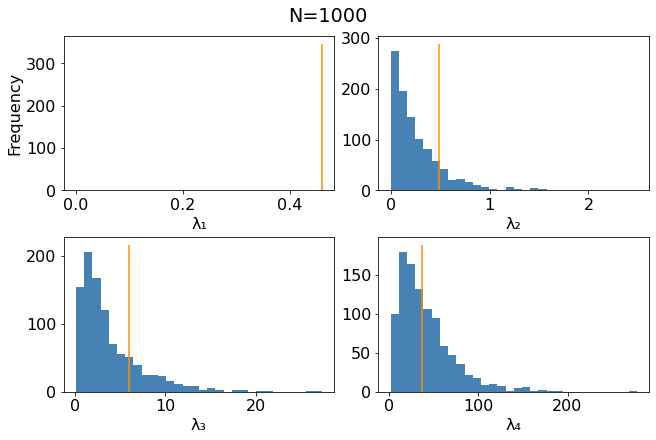

In [37]:
do_gridplot(ex4)

In [38]:
key = jax.random.PRNGKey(1123123)
key, k1 = jax.random.split(key, 2)
p = 16
nu = p
A = jax.random.uniform(key, shape=(p, p)).block_until_ready()

A = A @ A.T
A = A / (np.sqrt(A) @ np.sqrt(A))
A = A + np.eye(p)
A = np.array(A)
A[0, 3] = 0
A[3, 0] = 0

check_cov(A)
exp = set_up_synth_exp(k1, nu, A) # check invertible, pos def

check_cov(exp.cov_inv) # check inverse

assert np.alltrue(np.isnan(exp.K0)==False)
assert np.alltrue(np.isinf(exp.K0)==False)
assert np.alltrue(np.isnan(exp.samples.samples)==False)

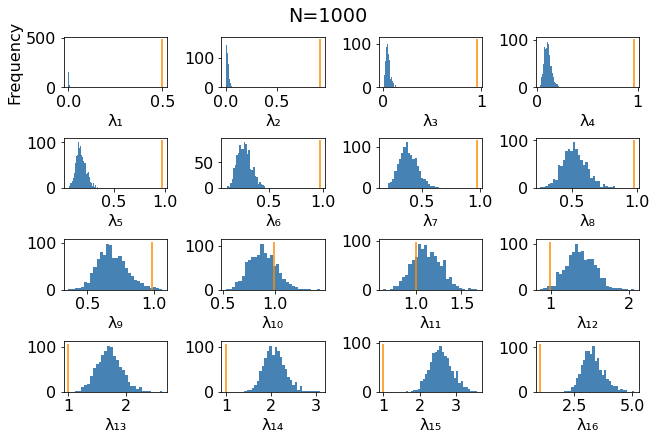

In [39]:
do_gridplot(exp)

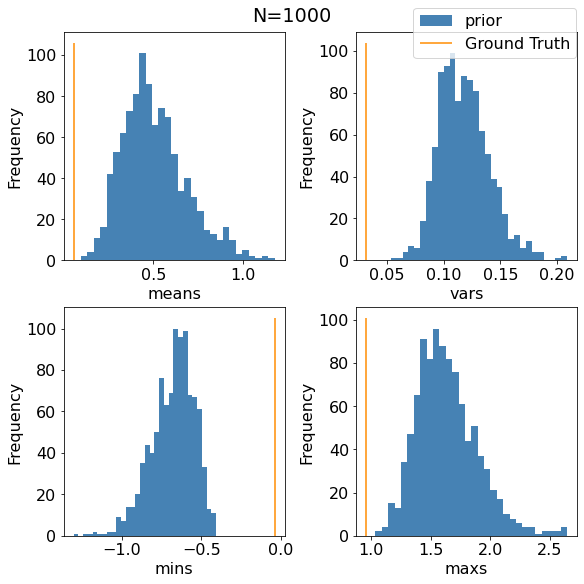

In [40]:
do_quad_plot(exp)

In [41]:
"""
Let's Do an Example with an 8 x 8 matrix
"""
p=16 # The length of the date vector
nu = p
n_trial = 4 # The number of AP-MS trials
factor = 4

# Generate the Ground Truth Network
key = jax.random.PRNGKey(22)
keys = jax.random.split(key, 10)
A = jax.random.bernoulli(keys[0], shape=(p, p))
diag_idx = np.diag_indices(p)
A = np.tril(A) + np.tril(A).T
A = np.array(A)
A[diag_idx] = 0
A = np.array(A, dtype=int)

# Generate the K_theta, the simulate known precicion matrix

K_theta = jax.random.uniform(keys[1], minval=-1., maxval=1.,  shape=(p, p))
K_theta = np.array(K_theta)
K_theta /= factor
K_theta[np.where(A == 0)] = 0
K_theta = np.tril(K_theta, k=-1) + np.tril(K_theta, k=-1).T
K_theta[diag_idx] = 1 + jax.random.normal(keys[2], shape=(p,))/4

check_cov(K_theta)
#assert np.sum(K_theta[diag_idx]) == p

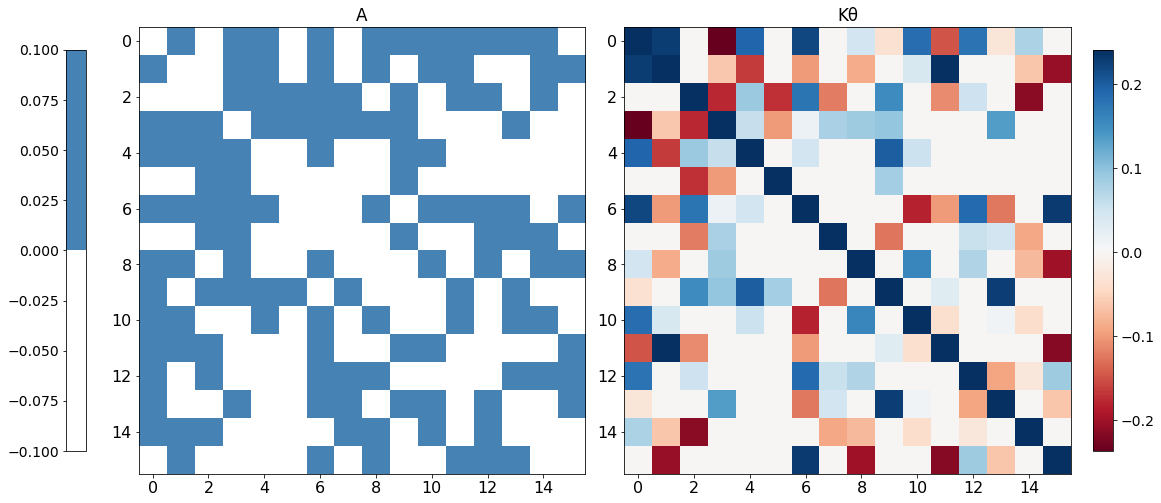

In [42]:
def ground_truth_pair_plot(A, K, title1="", title2="", cmap1="nipy_spectral", cmap2="CMRmap", 
                          factor=1.,
                          vmin1=None, vmax1=None,
                          vmin2=None, vmax2=None):
    font_rc = {"size": 14, "family": "sans-serif"}

    scale = 16
    w = 1 * scale
    h = 1 * scale
    cbar_scale = 0.35

    fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios':[1, 1],
                                               'height_ratios':[1]}, layout="constrained")

    plt.rc("font", **font_rc)
    fig.set_figheight(h)
    fig.set_figwidth(w)
    ax = axs[0]

    if not vmin1:
        vmin1 = np.min(A)
    if not vmax1:
        vmax1 = 2*np.median(A)
        
    covim = ax.imshow(A, vmin=vmin1, vmax=vmax1, cmap=cmap1)
    fig.colorbar(covim, ax=ax, location="left", shrink=cbar_scale)
    ax.set_title(title1)
    #ax.legend()

    ax = axs[1]
    ax.set_title(title2)
    
   # if type(cmap2) == str:
   #     cmap2 = matplotlib.colors.Colormap(cmap2)
    K_plot = K.copy()
    
    K_plot[np.diag_indices(len(K_plot))] = np.max(np.tril(K_plot, k=-1))
    
    if not vmin2:
        vmin2 = np.min(K_plot)
    if not vmax2:
        vmax2 = None
    precim = ax.imshow(K_plot, vmin=vmin2, vmax=vmax2, cmap=cmap2)
    
    #bounds = [-1/factor, 1/factor]
    #cnorm = matplotlib.colors.BoundaryNorm(bounds, cmap2.N)

    fig.colorbar(precim, ax=ax, location="right", shrink=cbar_scale)
    #plt.suptitle(, y=0.75)
    plt.show()
    
cmap1 = matplotlib.colors.ListedColormap(['w', 'steelblue'])


ground_truth_pair_plot(A, K_theta, title1="A", 
                       title2="K" + u"\u03B8"
                       , cmap1=cmap1,
                       cmap2 = "RdBu")

check_cov(K_theta)

In [43]:
def get_exp(key, nu, p, n, n_samples, V, K_theta, K0, n_trial):
    keys = jax.random.split(key)
    Ks = sample_from_prior(keys[0], nu, p, n_samples, V)
    K_theta = np.array(K_theta)
    K0 = np.array(K0)
    SynthExper = namedtuple("SynthExp", "cov cov_inv nu n p K0 n_samples key samples")
    exp = SynthExper(np.array(jsp.linalg.inv(K_theta)), K_theta, nu, n_trial, p, K0, n_samples, keys[1], Ks)
    return exp

In [44]:
# p length of the data vector
#assert np.sum(K_theta[diag_idx]) == p, f"{p, np.sum(K_theta[diag_idx])}"


K0 = np.ones(shape=(p, p)) * -0.1
#diag_K0 = jax.random.uniform(keys[2], minval=0, maxval=0.01, shape=(p, ))
K0[np.diag_indices(p)] = 2
check_cov(K0)
n_samples = 1000
V = K0 / p

check_cov(V)

In [45]:
def get_exp(key, nu, p, n, n_samples, V, K_theta, K0, n_trial):
    keys = jax.random.split(key)
    Ks = sample_from_prior(keys[0], nu, p, n_samples, V)
    K_theta = np.array(K_theta)
    K0 = np.array(K0)
    SynthExper = namedtuple("SynthExp", "cov cov_inv nu n p K0 n_samples key samples")
    exp = SynthExper(np.array(jsp.linalg.inv(K_theta)), K_theta, nu, n_trial, p, K0, n_samples, keys[1], Ks)
    return exp

In [46]:
nu = p-1
exp = get_exp(key, nu, p, n, n_samples, V, K_theta, K0, n_trial)

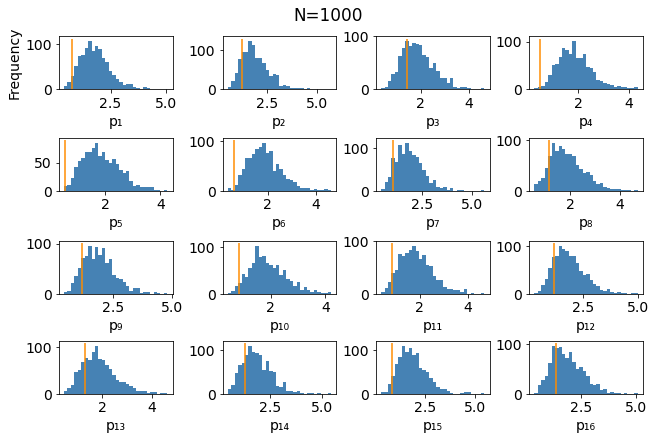

In [47]:
do_gridplot(exp, check_finite=False, decomposition="prec")

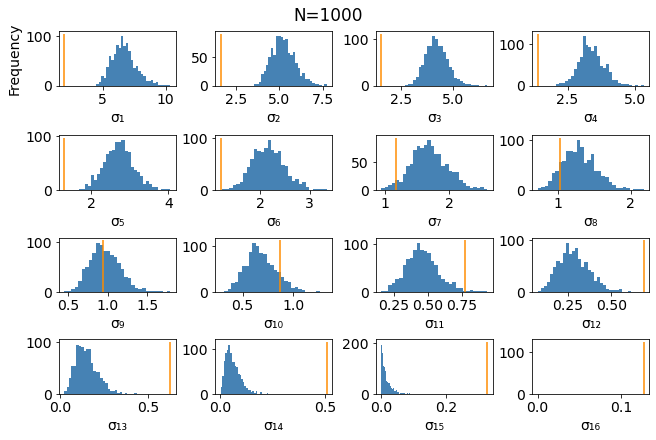

In [48]:
do_gridplot(exp, decomposition="svd")

In [49]:
K0 = K_theta
diag = np.diag_indices(p)
#diag_K0 = jax.random.uniform(keys[2], minval=0, maxval=0.01, shape=(p, ))

check_cov(K0)
n_samples = 1000



nu = p - 2

V = K0 / (nu)

check_cov(V)

exp = get_exp(key, nu, p, n, n_samples, V, K_theta, K0, n_trial)

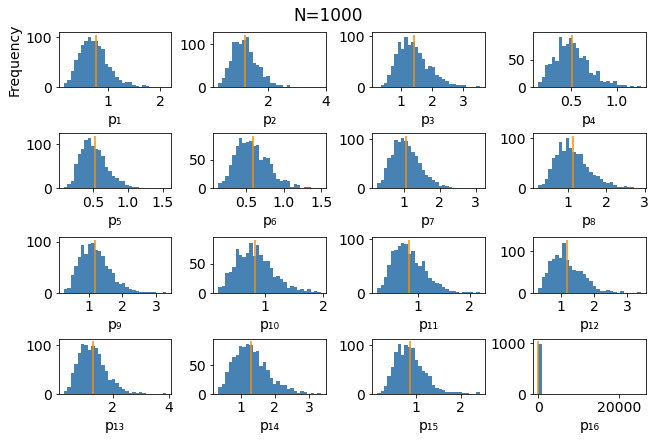

In [50]:
do_gridplot(exp, decomposition="prec")

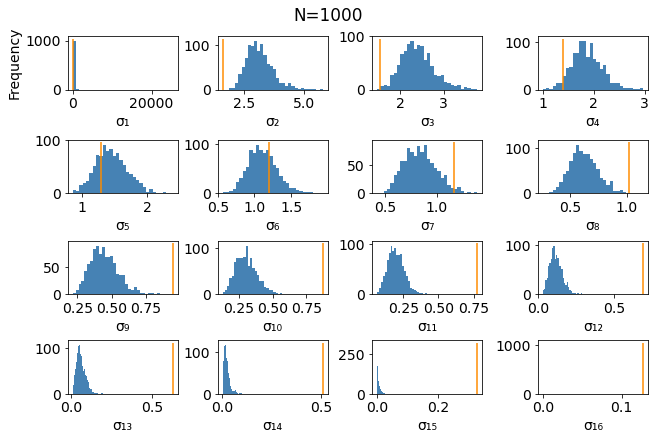

In [51]:
do_gridplot(exp, decomposition="svd")

In [52]:
# Conclusion - setting a prior of K_theta is worse. Perhaps because of the zeros

In [53]:
K0 = np.eye(p)
diag = np.diag_indices(p)
#diag_K0 = jax.random.uniform(keys[2], minval=0, maxval=0.01, shape=(p, ))

check_cov(K0)
n_samples = 10000



check_cov(V)
nu = p - 2
V = K0 / (nu)

exp = get_exp(key, nu, p, n, n_samples, V, K_theta, K0, n_trial)

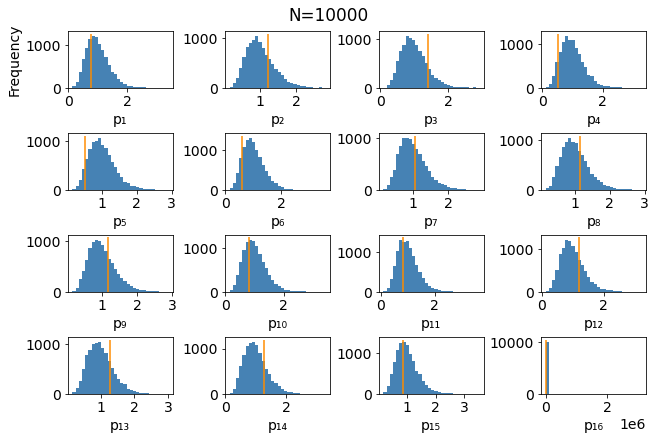

In [54]:
do_gridplot(exp, decomposition="prec")

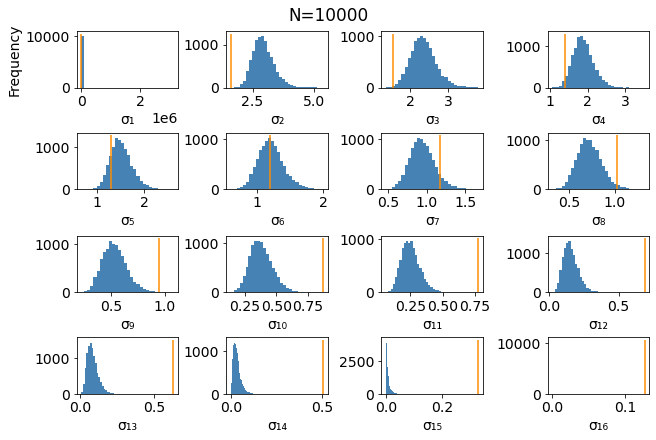

In [55]:
do_gridplot(exp, decomposition="svd")

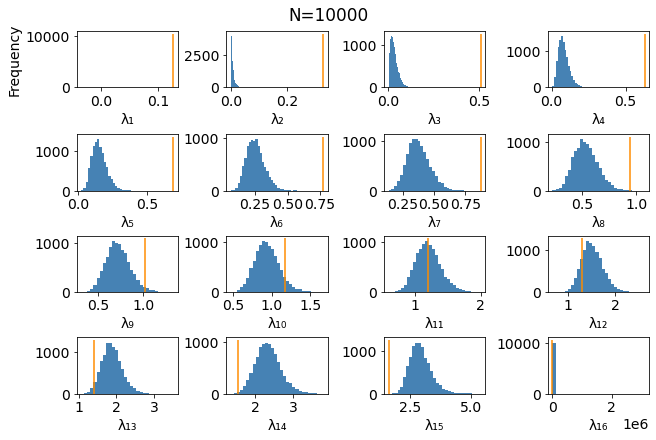

In [56]:
do_gridplot(exp)

In [57]:
jsp.linalg.eigh(K_theta, eigvals_only=True)

DeviceArray([0.12710875, 0.32778302, 0.5068595 , 0.62836367, 0.6874886 ,
             0.77513534, 0.8722637 , 0.94442457, 1.021332  , 1.1691127 ,
             1.1951934 , 1.296788  , 1.3946395 , 1.5458019 , 1.621648  ,
             1.9305947 ], dtype=float32)

In [58]:
K_theta[diag]

array([0.7641883 , 1.2155073 , 1.4021075 , 0.51587594, 0.51886755,
       0.58678687, 1.066786  , 1.1419272 , 1.1748396 , 0.8296654 ,
       0.8241984 , 1.1906743 , 1.2722672 , 1.2898651 , 0.8705916 ,
       1.3803885 ], dtype=float32)

In [59]:
# Lets look at prior accuracy and precision
# TP TN FP FN
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve


def get_accuracies_and_precisions(A, exp):
    nedges = sp.special.binom(p, 2)

    AUROC = np.zeros(n_samples, dtype=float) # Average AUROC
    AUPRC = np.zeros(n_samples, dtype=float)
    for i, Ksamp in enumerate(np.array(exp.samples.samples)):
        assert Ksamp.shape == (p, p)
        minval = np.min(np.tril(Ksamp, k=-1))
        maxval = np.max(np.tril(Ksamp, k=-1))
        #assert minval < 0 < maxval
        d = maxval - minval

        LT = A[np.tril_indices(p, k=-1)]
        LTK = Ksamp[np.tril_indices(p, k=-1)]
        LT = np.array(LT)
        LTK = np.array(np.abs(LTK)) # Use magnitude from 0 

        #assert np.all(LT == LTK)
        y_test = np.ravel(LT)
        y_score = np.ravel(LTK)
        #assert np.all(y_test == y_score)
        #assert np.sum(y_test) > 0
        
        fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_score)
        precision, recall, thresholds_prec = sklearn.metrics.precision_recall_curve(y_test, y_score)

        #AP = sklearn.metrics.average_precision_score(y_test, y_true)
        area_under_roc = sklearn.metrics.auc(fpr, tpr)
        area_under_prc = sklearn.metrics.auc(recall, precision)

        AUROC[i] = area_under_roc
        AUPRC[i] = area_under_prc
        
        #assert APs.shape == (n_samples, )
        #assert AAUROCs.shape == (n_samples, )
    
    return AUROC, AUPRC, thresholds, thresholds_prec

In [60]:
def euclidian_off_diagonal_distance_squared(A, B):
    Aeuc = A[np.tril_indices(len(A), k=-1)]
    Beuc = B[np.tril_indices(len(B), k=-1)]
    
    Aeuc = np.ravel(Aeuc)
    Beuc = np.ravel(Beuc)
    
    distance = np.sum((Aeuc**2 - Beuc**2))
    return distance
    
    
    

In [61]:
# Generate the Ground Truth Network
key = jax.random.PRNGKey(22)
keys = jax.random.split(key, 10)
A = jax.random.bernoulli(keys[0], shape=(p, p))
diag_idx = np.diag_indices(p)
A = np.tril(A) + np.tril(A).T
A = np.array(A)
A[diag_idx] = 0
A = np.array(A, dtype=int)

# Generate the K_theta, the simulate known precicion matrix
del K_theta
K_theta = jax.random.uniform(keys[1], minval=-1., maxval=1.,  shape=(p, p))
K_theta = np.array(K_theta)
K_theta /= factor

K_theta[0:10] += 0.05
K_theta[4:7] += 0.3
K_theta[4, 3] = 1
K_theta[9, 2] = -1
K_theta[7:15, 7:15] -= 0.2
K_theta[5:9, 5:9] += 0.1

K_theta[np.where(A == 0)] = 0
K_theta = np.tril(K_theta, k=-1) + np.tril(K_theta, k=-1).T
K_theta[diag_idx] = 1 + jax.random.normal(keys[2], shape=(p,))/4


K_theta[0, 0] = 10
K_theta[1, 1] = 1
K_theta[2, 2] = 2
K_theta[3, 3] = 5
K_theta[4, 4] = 12
K_theta[5, 5] = 231
K_theta[6, 6] = 10121
K_theta[7, 7] = 100232
K_theta[8, 8] = 999999
K_theta[9, 9] = 1283828
K_theta[10, 10] = 4
K_theta[11, 11] = 4
K_theta[12, 12] = 5
K_theta[13, 13] = 9
K_theta[14, 14] = 20
K_theta[15, 15] = 40

#K_theta = sp.linalg.inv(K_theta)


#K_theta[10, 10] = 7
K0 = K_theta
diag = np.diag_indices(p)
#diag_K0 = jax.random.uniform(keys[2], minval=0, maxval=0.01, shape=(p, ))

check_cov(K0)
n_samples = 1000



V = K0 / p

check_cov(V)



# Data for fitting the posterior

n_data_replicates = 4
data = jax.random.multivariate_normal(keys[4], np.zeros(p), jsp.linalg.inv(K_theta), 
                                      shape=(n_data_replicates,))
data = data.T
U = np.zeros((p, p))

for i in range(n_data_replicates):
    assert data.shape == (p, n_data_replicates)
    z = jnp.zeros((p, 1))
    z = z.at[:, 0].set(data[:, i])
    assert z.shape == ((p, 1))
    adder = z @ z.T
    assert adder.shape == (p, p)
    U = U + adder
    assert U.shape == (p, p)
assert i==3

Vpost = jsp.linalg.inv(jsp.linalg.inv(V) + data @ data.T)
nupost = nu + n_data_replicates
check_cov(Vpost)

nu = p - 1
post_exp = get_exp(key, nu + 4, p, n, n_samples, V + data @ data.T, K_theta, K0, n_trial)

In [62]:
# Posterior, fitting to the data
post_exp = get_exp(key, nu + n_data_replicates, p, n, n_samples, V + data @ data.T, K_theta, K0, n_trial)

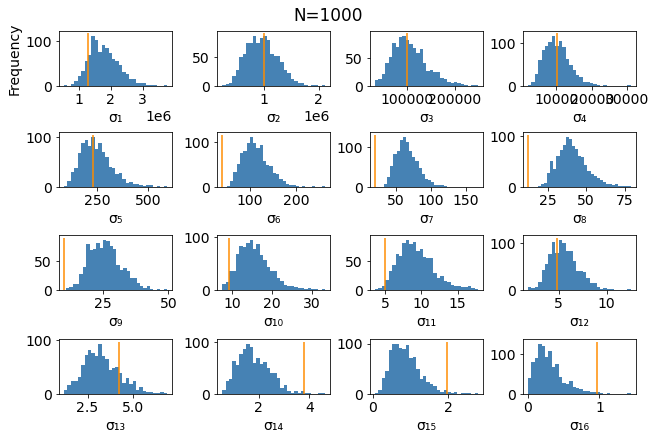

In [63]:
do_gridplot(post_exp, decomposition="svd")

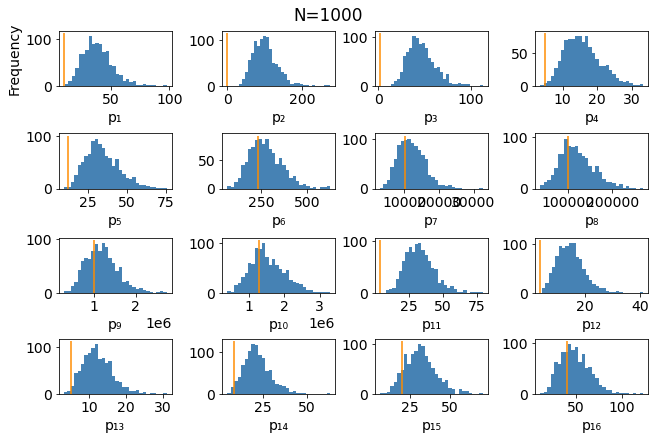

In [64]:
do_gridplot(post_exp, decomposition="prec")

In [65]:

accs, precs, t, tps = get_accuracies_and_precisions(A, post_exp)
plot_accuracies_and_precisions(accs, precs, suptitle=f"Prior accuracy and precision for balanced data")

NameError: name 'plot_accuracies_and_precisions' is not defined

In [ ]:
from functools import partial

get_eud = partial(euclidian_off_diagonal_distance_squared, B=np.array(K_theta))

distance_squared = np.array(list(map(get_eud, exp.samples.samples)))
logd = np.log10(distance_squared)

plt.hist(logd, bins=100)
plt.show()

In [ ]:
distance_squared = np.array(list(map(get_eud, post_exp.samples.samples)))
logd = np.log10(distance_squared)

In [ ]:
plt.hist(logd, bins=100)
plt.show()

In [ ]:

plt.imshow(np.log10(V), cmap=cmap)
plt.title(f"log10 prior V")
plt.colorbar()

In [ ]:
cmap = "twilight_shifted"
cmap = "PuOr"
cmap = "seismic"
#cmap = "ocean" # "slategrey" # "steelblue" #whitesmoke
cmap1 = matplotlib.colors.ListedColormap(['w', 'lightskyblue'])
ground_truth_pair_plot(A, K_theta, title1="A", 
                       title2="K" + u"\u03B8"
                       ,cmap1=cmap1,
                       cmap2 = cmap)

In [ ]:
assert np.allclose(jsp.linalg.inv(K_theta), sp.linalg.inv(K_theta))

In [ ]:
U = data @ data.T
ground_truth_pair_plot(U, 
                       K_theta,
                       cmap1=cmap, 
                       cmap2=cmap,
                       vmin1=-3.5,
                       vmax1=3.5,
                       vmin2=np.min(K_theta))#,
                      # vmax2=np.max(K_theta))

In [ ]:
ground_truth_pair_plot(U, sp.linalg.inv(K_theta), cmap1=cmap, cmap2=cmap,
                       vmin1=-3.5,
                       vmax1=3.5,
                       vmin2=np.min(sp.linalg.inv(K_theta)),
                       vmax2=0.06)

In [ ]:
data100 = jax.random.multivariate_normal(keys[5], jnp.zeros(p), sp.linalg.inv(K_theta), shape=(100,)).T
U100 = data100 @ data100.T

In [ ]:
ground_truth_pair_plot(U100, sp.linalg.inv(K_theta), cmap1=cmap, cmap2=cmap,
                       vmin1=-3.5,
                       vmax1=3.5,
                       vmin2=np.min(sp.linalg.inv(K_theta)),
                       vmax2=0.06)

In [ ]:
key = jax.random.PRNGKey(13)
key, k1 = jax.random.split(key)
key, k1 = jax.random.split(k1)

shift = 0
data3 = jax.random.multivariate_normal(key, jnp.zeros(p), inv(K_theta), shape=(3, )).T + shift



U3 = (data3 @ data3.T)
assert U3.shape == (p, p)

key, k1 = jax.random.split(k1)
data9 = jax.random.multivariate_normal(key, jnp.zeros(p), inv(K_theta), shape=(9, )).T + shift
U9 = (data9 @ data9.T)
assert U9.shape == (p, p)

key, k1 = jax.random.split(k1)
data16 = jax.random.multivariate_normal(key, jnp.zeros(p), inv(K_theta), shape=(16, )).T + shift
U16 = (data16 @ data16.T)
assert U16.shape == (p, p)

key, k1 = jax.random.split(k1)
data50 = jax.random.multivariate_normal(key, jnp.zeros(p), inv(K_theta), shape=(50, )).T + shift
U50 = (data50 @ data50.T)
assert U16.shape == (p, p)

cs = ['r', 'g', 'b', 'k']
l = [3, 9, 16, 50]
for i, U in enumerate([U3 / 3, U9 / 9, U16 / 16, U50 / 50]):
    
    plt.plot(inv(K_theta)[diag], U[diag], f"{cs[i]}.", label=l[i])
plt.legend()
plt.show()

In [ ]:
for i, U in enumerate([inv(U3/3), inv(U9/9), inv(U16/16), inv(U50/50 )]):
    U = np.log10(U)
    plt.plot(np.log10(K_theta[diag]), U[diag], f"{cs[i]}.", label=l[i])
plt.legend()
plt.show()

In [ ]:
ground_truth_pair_plot(U3, np.array(U9), cmap1=cmap, cmap2=cmap)

In [ ]:
def minmax(U):
    return np.min(U), np.max(U)

def rrange(U):
    return np.max(U) - np.min(U)

In [ ]:
myl = [U3 / 3, U9 / 9, U16 / 16, U50 / 50, U100 / 100]
for U in myl:
    print(minmax(U), rrange(U))

print('\n')

for U in myl:
    U = inv(U)
    print(minmax(U), np.log10(rrange(U)))

In [ ]:
print(minmax(K_theta), np.log10(rrange(K_theta)))

In [ ]:
key = jax.random.PRNGKey(13)
nu = 15
n_samples = 1000
Ks = sample_from_prior(key, nu, p=16, n_samples=n_samples, K_0=K_theta / nu)

average1000 = np.mean(Ks.samples, axis=0)
variances1000 = np.var(Ks.samples, axis=0)

In [ ]:
plotting_vscale = 2

In [ ]:
cmap = "seismic"
scale1 = plotting_vscale
scale2 = scale1
ground_truth_pair_plot(average1000, K_theta, cmap1=cmap, cmap2=cmap,
                       vmin1=-scale1, vmax1=scale1,
                       vmin2=-scale2, vmax2=scale2
                       )
s = '{:,}'.format(n_samples)
print(f"{s}")
# Not scaling K_theta is bad

In [ ]:
# Simple test of the Wishart Distribution
key = jax.random.PRNGKey(13)
nu = 15
n_samples = 100000000
Ks100mil = sample_from_prior(key, nu, p=16, n_samples=100000, K_0=K_theta / nu)

In [ ]:
average100mil = np.mean(Ks100mil.samples, axis=0)
variances100mil = np.var(Ks100mil.samples, axis=0)

In [ ]:
scale1 = plotting_vscale
scale2 = scale1
ground_truth_pair_plot(np.array(average100mil), np.array(average1000), cmap1=cmap, cmap2=cmap,
                       vmin1=-scale1, vmax1=scale1,
                       vmin2=-scale2, vmax2=scale2
                       )
s = '{:,}'.format(n_samples)
print(f"{s}")
# Not scaling K_theta is bad

In [ ]:
'{:,}'.format(10000)

In [ ]:
scale1 = 10
scale2 = scale1
cmap = "gnuplot2"
ground_truth_pair_plot(np.log10(variances100mil), np.log10(np.array(variances1000)), cmap1=cmap, cmap2=cmap,
                      vmin1=0, vmax1=scale1, vmin2=0, vmax2=scale2)

In [ ]:
K_theta[diag]

In [ ]:
ground_truth_pair_plot(Ks.samples[9], K_theta, cmap1=cmap, cmap2=cmap,
                      vmin1=-1, vmax1=1, vmin2=-1, vmax2=1)

In [ ]:
# Simple test of the Wishart Distribution
key = jax.random.PRNGKey(13)
Ks = sample_from_prior(key, 100, p=16, n_samples=1000, K_0=K_theta / (64**2))

average = np.mean(Ks.samples, axis=0)
variances = np.var(Ks.samples, axis=0)

ground_truth_pair_plot(average, K_theta, cmap1=cmap, cmap2=cmap,
                       )

In [ ]:
ground_truth_pair_plot(variances, K_theta, cmap1=cmap, cmap2=cmap)

In [ ]:
ground_truth_pair_plot(Ks.samples[6], K_theta, cmap1=cmap, cmap2=cmap)

In [ ]:
x = sp.linalg.inv(K_theta)[diag]
U4 = U
data50 = jax.random.multivariate_normal(keys[10], jnp.zeros(p), cov=sp.linalg.inv(K_theta), shape=(50, )).T

U50 = data50 @ data50.T
y = U4[np.diag_indices(len(U4))] / 4
rho, _ = sp.stats.pearsonr(x, y)
rho = np.round(rho, decimals=3)

plt.plot(x, y, 'r.', label=f"U4 rho {rho}")
y = U50[np.diag_indices(len(U50))] / 50

rho, _ = sp.stats.pearsonr(x, y)
rho = np.round(rho, decimals=3)

plt.plot(x, y, 'b.', label=f"U50 rho {rho}")
plt.plot(x, U100[np.diag_indices(len(U100))] / 100, 'k.', label="U100")
plt.legend()
plt.ylabel("U diagonal elements")
plt.xlabel('COV diagonal elements')
plt.show()

In [ ]:
inv = sp.linalg.inv
invA = inv(A)

In [ ]:
diag

In [ ]:
np.allclose(inv(A * 2), invA / 2)

In [ ]:
np.allclose(inv(A / 9.3), invA * 9.3)

In [ ]:
assert K_theta.shape == (p, p)
diag = np.diag_indices(p)
x = np.log10(K_theta[diag])

assert data.shape == (p, 4)
y = inv((data @ data.T))
assert y.shape == (p, p)
y = np.log10(y[diag] * 4)

plt.plot(x, y, 'r.', label=f"U4 rho")

data7 = jax.random.multivariate_normal(keys[7], jnp.zeros(p), cov=jsp.linalg.inv(K_theta), shape=(7, )).T
U7 = (data7 @ data7.T)
U7 = np.array(U7)

assert U7.shape == (p, p)
y = inv(U7)[np.diag_indices(len(U7))] * 7
y = np.log10(y)

plt.plot(x, y, 'kx', label=f"U7 rho")


y = inv(U50)[np.diag_indices(len(U50))] * 50

rho, _ = sp.stats.pearsonr(x, y)
rho = np.round(rho, decimals=3)

y = np.log10(y)

plt.plot(x, y, 'b.', label=f"U50 rho {rho}")
y =  inv(U100)[np.diag_indices(len(U100))] * 100
y = np.log10(y)

plt.plot(x, y, 'k.', label="U100")
plt.legend()
plt.ylabel("log inv U diagonal elements")
plt.xlabel('log inv COV diagonal elements')
plt.show()

In [ ]:
U50[diag]

In [ ]:
ground_truth_pair_plot(np.log10(K_theta), np.array(data @ data.T),
                      cmap1=cmap,
                      cmap2=cmap,
                      vmin1=np.min(K_theta),
                      vmax1=np.max(K_theta),
                      )

In [ ]:
np.min(U), np.max(U), (np.max(U) - np.min(U)) / 2

In [ ]:
ground_truth_pair_plot(K_theta, np.array(Vpost), cmap1=cmap, cmap2=cmap)

In [ ]:
(data @ data.T).shape

In [ ]:
do_gridplot(exp, decomposition="prec")

In [ ]:
do_gridplot(exp, decomposition="svd")

In [ ]:
assert A.shape == (p, p)
assert np.sum(A[diag]) == 0
accs, aps, t, tp = get_accuracies_and_precisions(A, exp)

In [ ]:
plot_accuracies_and_precisions(accs, aps, suptitle=f"Prior accuracy and precision for balanced data")

In [ ]:
# Diagonal Elements
K0 = np.eye(p)
K0[np.diag_indices(p)] = K_theta[np.diag_indices(p)]
check_cov(K0)
n_samples = 1000

V = K0 / p

check_cov(V)

nu = p - 1
exp = get_exp(key, nu, p, n, n_samples, V, K_theta, K0, n_trial)

assert (data @ data.T).shape == (p, p)

Vpost = jsp.linalg.inv(jsp.linalg.inv(K0) + data @ data.T) / p
nupost = nu + n_data_replicates
check_cov(Vpost)

nu = p - 1
post_exp = get_exp(key, nu, p, n, n_samples, Vpost, K_theta, K0, n_trial)

In [ ]:
cmap = "twilight_shifted"
cmap = "PuOr"
cmap = "seismic"
#cmap = "ocean" # "slategrey" # "steelblue" #whitesmoke
cmap1 = matplotlib.colors.ListedColormap(['w', 'lightskyblue'])
ground_truth_pair_plot(A, K_theta, title1="A", 
                       title2="K" + u"\u03B8"
                       ,cmap1=cmap1,
                       cmap2 = cmap)

In [ ]:
plt.imshow(np.log10(V), cmap=cmap)
plt.title(f"log10 prior V")
plt.colorbar()

In [ ]:
do_gridplot(exp, decomposition="prec")

In [ ]:
do_gridplot(exp, decomposition="svd")

In [ ]:
do_gridplot(post_exp, decomposition="prec")

In [ ]:
do_gridplot(post_exp, decomposition="svd")

In [ ]:
def flatten_tril_from_M(A, k=-1):
    Atril = np.array(A[np.tril_indices(len(A), k=k)])
    return np.ravel(Atril)
    

def mean_squared_error_lt(A, B):
    Amse = flatten_tril_from_M(A)
    Bmse = flatten_tril_from_M(B)
    
    error = Amse - Bmse
    error2 = error**2
    mse = (1/len(Amse)) * np.sum(error2)
    return mse

In [ ]:
from functools import partial

f = mean_squared_error_lt
f = partial(f, B=np.array(K_theta))

o = np.array(list(map(f, exp.samples.samples)))
logd = np.log10(o)

plt.hist(logd, bins=100)
print(np.median(logd), np.var(logd))
plt.show()

In [ ]:
f = mean_squared_error_lt
f = partial(f, B=np.array(K_theta))

o = np.array(list(map(f, post_exp.samples.samples)))
logd = np.log10(o)

plt.hist(logd, bins=100)
print(np.median(logd), np.var(logd))
plt.show()

In [ ]:
get_eud = partial(euclidian_off_diagonal_distance_squared, B=np.array(K_theta))

distance_squared = np.array(list(map(get_eud, post_exp.samples.samples)))
logd = np.log10(distance_squared)
print(np.median(logd), np.var(logd))
plt.hist(logd, bins=100)
plt.show()

In [ ]:
assert A.shape == (p, p)
assert np.sum(A[diag]) == 0
assert np.alltrue(A == A.T)
#check_cov(A)
assert np.sum(A) != 0
aacs, aps, t, tp = get_accuracies_and_precisions(A, exp)
plot_accuracies_and_precisions(aacs, aps, suptitle="Diagonal Prior")

In [ ]:
# Dummy test for plotting accuracies and precisions
SynthExper = namedtuple("SynthExp", "cov cov_inv nu n p K0 n_samples key samples")
exp_test = exp
As = np.zeros((n_samples, p, p))
Samples = namedtuple("Samples", "samples")

for i in range(n_samples):
    As[i] = A
As = Samples(As)
exp_test = SynthExper(A, A, nu, n, p, A, n_samples, key, As)
accs_test, precs_test, ts, tps = get_accuracies_and_precisions(A, exp_test)

In [ ]:
plot_accuracies_and_precisions(accs_test, precs_test, suptitle="DEBUG")

In [ ]:
def plot_accuracies_and_precisions(aacs, precs, 
                                   xlabel1="AUROC",
                                   ylabel1="Frequency",
                                   xlabel2="AUPRC",
                                   suptitle=""):
    bins=20

    plt.subplot(121)

    plt.hist(aacs, bins=bins)
    plt.xlabel(xlabel1)
    plt.ylabel(ylabel1)
    plt.subplot(122)
    plt.hist(precs, bins=bins)
    plt.xlabel(xlabel2)
    plt.yticks([])
    plt.suptitle(suptitle)
    plt.show()

In [ ]:
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % area,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Lets do a misfit prior
K0 = jax.random.exponential(key, shape=(p, p))
K0 = K0 * np.eye(p)
K0 = K0 * np.arange(-8, 8, 1)
K0 = np.array(K0)
K0[np.diag_indices(p)] += 10
V = K0 / (nu)
#check_cov(V)

In [ ]:
plt.imshow(np.log10(V), cmap=cmap)
plt.title(f"log10 prior V")
plt.colorbar()

In [ ]:
exp = get_exp(key, nu, p, n, n_samples, V, K_theta, K0, n_trial)

In [ ]:
do_gridplot(exp, decomposition="prec")

In [ ]:
do_gridplot(exp, decomposition="svd")

In [ ]:
accs, precs, t, tp = get_accuracies_and_precisions(A, exp)

In [ ]:
plot_accuracies_and_precisions(accs, precs, suptitle=f"Prior accuracy and precision misfit prior")

In [ ]:
# Same game but with imbalanced data



In [ ]:
# Generate the Ground Truth Network
key = jax.random.PRNGKey(22)
keys = jax.random.split(key, 10)
A = jax.random.bernoulli(keys[0], p=0.01, shape=(p, p))
diag_idx = np.diag_indices(p)
A = np.array(A)
A[5, 3] = 1
A = np.tril(A) + np.tril(A).T

A[diag_idx] = 0
A = np.array(A, dtype=int)

# Generate the K_theta, the simulate known precicion matrix
del K_theta
K_theta = jax.random.uniform(keys[1], minval=-1., maxval=1.,  shape=(p, p))
K_theta = np.array(K_theta)
K_theta /= factor

K_theta[0:10] += 0.05
K_theta[4:7] += 0.3
K_theta[4, 3] = 1
K_theta[9, 2] = -1
K_theta[7:15, 7:15] -= 0.2
K_theta[5:9, 5:9] += 0.1


K_theta[np.where(A == 0)] = 0
K_theta = np.tril(K_theta, k=-1) + np.tril(K_theta, k=-1).T
K_theta[diag_idx] = 1 + jax.random.normal(keys[2], shape=(p,))/4


K_theta[0, 0] = 10
K_theta[1, 1] = 1
K_theta[2, 2] = 2
K_theta[3, 3] = 5
K_theta[4, 4] = 12
K_theta[5, 5] = 231
K_theta[6, 6] = 10121
K_theta[7, 7] = 100232
K_theta[8, 8] = 999999
K_theta[9, 9] = 1283828
K_theta[10, 10] = 4
K_theta[11, 11] = 4
K_theta[12, 12] = 5
K_theta[13, 13] = 9
K_theta[14, 14] = 20
K_theta[15, 15] = 40

#K_theta = sp.linalg.inv(K_theta)


#K_theta[10, 10] = 7
K0 = K_theta
diag = np.diag_indices(p)
#diag_K0 = jax.random.uniform(keys[2], minval=0, maxval=0.01, shape=(p, ))

check_cov(K0)
n_samples = 1000

V = K0 / p

check_cov(V)

nu = p - 1
exp = get_exp(key, nu, p, n, n_samples, V, K_theta, K0, n_trial)

In [ ]:
plt.imshow(np.log10(V), cmap=cmap)
plt.title(f"log10 prior V")
plt.colorbar()

In [ ]:
cmap = "twilight_shifted"
cmap = "PuOr"
cmap = "seismic"
#cmap = "ocean" # "slategrey" # "steelblue" #whitesmoke
cmap1 = matplotlib.colors.ListedColormap(['w', 'lightskyblue'])
ground_truth_pair_plot(A, K_theta, title1="A", 
                       title2="K" + u"\u03B8"
                       ,cmap1=cmap1,
                       cmap2 = cmap)

In [ ]:
npos = np.sum(np.tril(A, k=-1))
nk = sp.special.binom(p, 2)
nneg = nk - npos
print(npos, nk, nneg)

In [ ]:
do_gridplot(exp, decomposition="prec")

In [ ]:
do_gridplot(exp, decomposition="svd")

In [ ]:
accs, precs, t, tp = get_accuracies_and_precisions(A, exp)

In [ ]:
plot_accuracies_and_precisions(accs, precs, suptitle=f"Prior accuracy and precision misfit prior")

In [ ]:
# Generate the Ground Truth Network
key = jax.random.PRNGKey(22)
keys = jax.random.split(key, 10)
A = jax.random.bernoulli(keys[0], p=0.99, shape=(p, p))
diag_idx = np.diag_indices(p)
A = np.array(A)
A[5, 3] = 1
A = np.tril(A) + np.tril(A).T

A[diag_idx] = 0
A = np.array(A, dtype=int)

# Generate the K_theta, the simulate known precicion matrix
del K_theta
K_theta = jax.random.uniform(keys[1], minval=-1., maxval=1.,  shape=(p, p))
K_theta = np.array(K_theta)
K_theta /= factor

K_theta[0:10] += 0.05
K_theta[4:7] += 0.3
K_theta[4, 3] = 1
K_theta[9, 2] = -1
K_theta[7:15, 7:15] -= 0.2
K_theta[5:9, 5:9] += 0.1


K_theta[np.where(A == 0)] = 0
K_theta = np.tril(K_theta, k=-1) + np.tril(K_theta, k=-1).T
K_theta[diag_idx] = 1 + jax.random.normal(keys[2], shape=(p,))/4


K_theta[0, 0] = 10
K_theta[1, 1] = 1
K_theta[2, 2] = 2
K_theta[3, 3] = 5
K_theta[4, 4] = 12
K_theta[5, 5] = 231
K_theta[6, 6] = 10121
K_theta[7, 7] = 100232
K_theta[8, 8] = 999999
K_theta[9, 9] = 1283828
K_theta[10, 10] = 4
K_theta[11, 11] = 4
K_theta[12, 12] = 5
K_theta[13, 13] = 9
K_theta[14, 14] = 20
K_theta[15, 15] = 40

#K_theta = sp.linalg.inv(K_theta)


#K_theta[10, 10] = 7
K0 = K_theta
diag = np.diag_indices(p)
#diag_K0 = jax.random.uniform(keys[2], minval=0, maxval=0.01, shape=(p, ))

check_cov(K0)
n_samples = 1000

V = K0 / p

check_cov(V)

nu = p - 1
exp = get_exp(key, nu, p, n, n_samples, V, K_theta, K0, n_trial)

In [ ]:
cmap = "twilight_shifted"
cmap = "PuOr"
cmap = "seismic"
#cmap = "ocean" # "slategrey" # "steelblue" #whitesmoke
cmap1 = matplotlib.colors.ListedColormap(['w', 'lightskyblue'])
ground_truth_pair_plot(A, K_theta, title1="A", 
                       title2="K" + u"\u03B8"
                       ,cmap1=cmap1,
                       cmap2 = cmap)

In [ ]:
plt.imshow(np.log10(V), cmap=cmap)
plt.title(f"log10 prior V")
plt.colorbar()

In [ ]:
do_gridplot(exp, decomposition="prec")

In [ ]:
do_gridplot(exp, decomposition="svd")

In [ ]:
accs, precs, t, tp = get_accuracies_and_precisions(A, exp)

In [ ]:
plot_accuracies_and_precisions(accs, precs)

In [ ]:
# Lets Generate Data



In [ ]:
example_string = "A0B1C2D3E4F5G6H7I8J9"

SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
SUP = str.maketrans("0123456789", "⁰¹²³⁴⁵⁶⁷⁸⁹")

print(example_string.translate(SUP))
print(example_string.translate(SUB))

In [ ]:
matplotlib.colors.Colormap(cmap1)

In [ ]:
A

In [ ]:
class FunctionSpace:
    """
    A vector space of functions from x in X to y in Y
    F: X -> Y
    """
    def __init__(self, f):
        if type(f) == FunctionSpace:
            self.f = f.f
        else:
            self.f = f
        
    def __call__(self, x):
        return self.f(x)
    
    def __add__(self, g):
        return FunctionSpace(lambda x: self.f(x) + g(x)) # be a member of the vector space
    
    def __radd__(self, g):
        return FunctionSpace(lambda x: self.f(x) + g(x))
    
    def __sub__(self, g):
        return FunctionSpace(lambda x: self.f(x) - g(x))
    
    def __rsub__(self, g):
        return FunctionSpace(lambda x: g(x) - self.f(x))
    
    def __mul__(self, lam):
        # scalar multiplication
        return FunctionSpace(lambda x: self.f(x) * lam)   
    
    def __rmul__(self, lam):
        return FunctionSpace(lambda x: self.f(x) * lam)

In [ ]:
fs = FunctionSpace

def f(x):
    return np.sqrt(x + 1)

def g(x):
    return x**2 + 2

def h(x):
    return x**2 + 9 / 3

def z(x):
    return x + 1

def q(x):
    return x + 1

In [ ]:
# Check our Assumptions

f = fs(f)
h = fs(h)
g = fs(g)

xs = [0, 2., np.array([[0, 1, 2],
                       [1., 1., -3.]])]

for x in xs:
    # Commutative over addition
    np.testing.assert_almost_equal( (f + g)(x), (g + f)(x)), f"{x}"

    # Scalar Multiplication
    np.testing.assert_almost_equal(0 * (f + h)(x), 0 * (h + f)(x))
    np.testing.assert_almost_equal(123 * (f + h)(x), (123 * f + 123 * h)(x))

    # Ascociative

    assert (h + (f + g))(3) == ((h + f) + g)(3)

    assert (f - f)(123498723489) == 0 # Additive Inverse
